<a href="https://colab.research.google.com/github/nvarasp/Project_IRWA/blob/main/Search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Search Engine

In this notebook, we will first gather data from twitter related to the Covid-19 topic. Then, we will build a search engine by preprocessing the data, contructing an inverted index and a ranking methodology.

### 0 - Imports and Setup

In this section, we mount drive and install and import the required libraries.

In [1]:
%%time
from google.colab import drive
drive.mount('/content/drive')

#OUTPUT_FILENAME = "/content/drive/My Drive/IRWA/FinalProject/data/blm_data.json"
OUTPUT_FILENAME = "/content/drive/My Drive/IRWA/FinalProject/data/covid19_data.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 396 µs, sys: 0 ns, total: 396 µs
Wall time: 316 µs


In [2]:
%%capture
!pip install config

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
from config import *
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime
import time
from wordcloud import WordCloud, ImageColorGenerator
import re
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1 - Data Collection

In this section, we gather data from twitter. The output will be stored in the file specified in the first cell. This step is optional, and can be controlled through the flag SCRAP_DATA.

In [4]:
SCRAP_DATA =False #if True we will gather data from twitter, false will use the specified file

In [5]:
## access token informations 
access_token1 = "1222829162873966592-bZFEBawAf3miUZbbEH29HHRw7NjPPM"
access_token_secret1 = "ZIt6kCYMFkRWHgqaq3Y8wVhv7X9bwDEBzFc0l94lDcnDN"

consumer_key1 = "fH09Y3OVJmPcEUE3tJ2rxipfg"
consumer_secret1 = "5tiWpOA9QtMc9EV6Jr7k9gSG0aZHyVwV20H9PHFG0mHyPl9q8d"

In [6]:
auth = OAuthHandler(consumer_key1, consumer_secret1)
auth.set_access_token(access_token1, access_token_secret1)
api = API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
class MyStreamListener(StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api, OUTPUT_FILENAME, stop_condition=10):
        """
        initialize the stream, with num. of tweets and saving the outputfile
        """
        
        # this line is needed to import the characteristics of the streaming API
        super(MyStreamListener, self).__init__()
        
        # to-count the number of tweets collected        
        self.num_tweets = 0
        
        # save filename
        self.filename = OUTPUT_FILENAME
        
        # stop-condition
        self.stop_condition = stop_condition
        

    def on_status(self, status):
        
        """
        this function runs each time a new bunch of tweets is retrived from the streaming
        """
        
        with open(self.filename, "a+") as f:
            tweet = status._json
            
            f.write(json.dumps(tweet) + '\n')
            #self.output.append(tweet)
            self.num_tweets += 1
        
            # Stop condition        
            if self.num_tweets <= self.stop_condition:
                return True
            else:
                return False
        

    def on_error(self, status):
        """
        function useful to handle errors. It's possible to personalize it 
        depending on the way we want to handle errors
        """
        
        print(status)
        #returning False in on_error disconnects the stream
        return False

In [8]:
%%time
if SCRAP_DATA:
  stop_condition = 1000

  l = MyStreamListener(api, OUTPUT_FILENAME, stop_condition)
  # here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
  stream = Stream(auth=api.auth, listener=l)


  # keywords we may want decide to track 
  TRACKING_KEYWORDS = ["#coronavirus","#covid-19","#corona","#SARSCoV2","#WearAMask","#stayhome","#quarantine","#quarantinelife","#lockdown","#pcr","#CoronavirusOutbreak"]

  stream.filter(
      track=TRACKING_KEYWORDS, 
      async=False, 
      languages = ["en"]
  )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


#### 1.1 **Report** Section 1: Data Collection

First, we will read the data from the file that contains the tweets.

In [9]:
with open(OUTPUT_FILENAME, "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

Then, we inspect our data.

In [10]:
df_tweets = pd.DataFrame.from_records(data)
df_tweets.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,extended_entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,display_text_range
0,Sat Dec 05 17:14:47 +0000 2020,1335271410781057025,1335271410781057025,RT @RichardAngwin: This sign should be display...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,"{'id': 1478280942, 'id_str': '1478280942', 'na...",None,None,None,None,{'created_at': 'Sat Dec 05 14:48:27 +0000 2020...,False,0,0,0,0,"{'hashtags': [{'text': 'WearAMask', 'indices':...","{'media': [{'id': 1335234584427040775, 'id_str...",False,False,False,low,en,1607188487130,NaN,NaN,NaN,NaN,NaN,NaN
1,Sat Dec 05 17:14:48 +0000 2020,1335271414736297986,1335271414736297986,RT @LynnSharig8: I’d rather wear a mask than a...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 48877205, 'id_str': '48877205', 'name':...",None,None,None,None,{'created_at': 'Sat Dec 05 16:53:02 +0000 2020...,False,0,0,0,0,"{'hashtags': [{'text': 'WearAMask', 'indices':...",NaN,False,False,NaN,low,en,1607188488073,NaN,NaN,NaN,NaN,NaN,NaN
2,Sat Dec 05 17:14:49 +0000 2020,1335271419656118273,1335271419656118273,RT @0MaxCooper0: My hospital in southeast #Pen...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 57992091, 'id_str': '57992091', 'name':...",None,None,None,None,{'created_at': 'Thu Dec 03 20:35:14 +0000 2020...,False,0,0,0,0,"{'hashtags': [{'text': 'Pennsylvania', 'indice...",NaN,False,False,NaN,low,en,1607188489246,NaN,NaN,NaN,NaN,NaN,NaN
3,Sat Dec 05 17:14:49 +0000 2020,1335271422646751235,1335271422646751235,COVID deaths will undoubtedly be additional to...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,None,"{'id': 168086103, 'id_str': '168086103', 'name...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,False,False,NaN,low,en,1607188489959,1.239260e+18,1239259644629004298,{'created_at': 'Sun Mar 15 18:38:18 +0000 2020...,"{'url': 'https://t.co/YNra0S2y8S', 'expanded':...",{'full_text': 'COVID deaths will undoubtedly b...,NaN
4,Sat Dec 05 17:14:50 +0000 2020,1335271426799132672,1335271426799132672,RT @GetWisdomDude: @mmpadellan #BunkerBoy Will...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,None,"{'id': 766547376, 'id_str': '766547376', 'name...",None,None,None,None,{'created_at': 'Sat Dec 05 16:14:03 +0000 2020...,False,0,0,0,0,"{'hashtags': [{'text': 'BunkerBoy', 'indices':...",NaN,False,False,NaN,low,en,1607188490949,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 1914 non-null   object 
 1   id                         1914 non-null   int64  
 2   id_str                     1914 non-null   object 
 3   text                       1914 non-null   object 
 4   source                     1914 non-null   object 
 5   truncated                  1914 non-null   bool   
 6   in_reply_to_status_id      132 non-null    float64
 7   in_reply_to_status_id_str  132 non-null    object 
 8   in_reply_to_user_id        142 non-null    float64
 9   in_reply_to_user_id_str    142 non-null    object 
 10  in_reply_to_screen_name    142 non-null    object 
 11  user                       1914 non-null   object 
 12  geo                        2 non-null      object 
 13  coordinates                2 non-null      objec

Next, we retrieve some interesting statistics such as the number of retweets, unique tweets and unique users.

In [12]:
def print_retweets_uniqueTweets_uniqueUsers(df_tweets):
    #list of 0 if tweet is not reteeweted/1 for retweet or not
    #np.count_nonzero = lambda x: 0 if str(x) == "nan" else 1
    retweets_ = df_tweets["retweeted_status"].apply(lambda x: 0 if str(x) == "nan" else 1)
    tot_retweets = sum(retweets_)
    unique_tweets = len(retweets_) - tot_retweets
    
    users_ = df_tweets.user.apply(lambda x: x["id"])
    
    tot_users = len(set(users_))
    
    print("The total number of retweets is: " + str(tot_retweets))
    print("The total number of unique tweets is: " + str(unique_tweets))
    print("The total number of unique users is: " + str(tot_users))


In [13]:
print_retweets_uniqueTweets_uniqueUsers(df_tweets)

The total number of retweets is: 1088
The total number of unique tweets is: 826
The total number of unique users is: 1628


Finally, we make a histogram of the most popular hasthags in our corpus.

In [14]:
def extract_hashtags():

    hashtags_lists = df_tweets["entities"].apply(lambda x: x["hashtags"])
    
    #modify the x[0] bc it is only taking the first hastag, and sometimes there are more
    hashtags = hashtags_lists.apply(lambda x: x[0]["text"].lower() if x != [] else None)
    
    hashtags_by_frequency = Counter(hashtags)
    hashtags_by_frequency = {k: hashtags_by_frequency[k] for k in hashtags_by_frequency if k!= None}
    
    return hashtags_by_frequency

In [15]:
hashtags_by_frequency = extract_hashtags()

In [16]:
df_hashtags = pd.DataFrame(list(hashtags_by_frequency.items()))
df_hashtags.columns = ["hashtag", "count"]
df_hashtags.set_index("hashtag", inplace=True)
df_hashtags.sort_values("count", inplace=True, ascending=False)

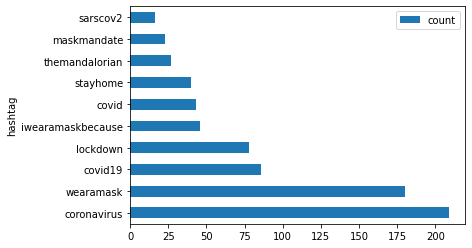

In [17]:
df_hashtags.head(10).plot.barh()
plt.show()

### 2 - Build the Search Engine

#### 2.1 Pre-processing the tweets

In [18]:
df_proc = df_tweets[["text","created_at", "favorite_count","retweet_count"]]
df_proc["username"]=[user['screen_name'] for user in df_tweets.user]
df_proc["hashtags"]=[entities['hashtags'] for entities in df_tweets.entities]
df_proc["url"] = ["https://twitter.com/twitter/statuses/"+id for id in df_tweets.id_str]

df_proc.rename(columns={'text':'Tweet', 'username':'Username', 'created_at':'Date', 'hashtags':'Hashtags', 'favorite_count':'Likes', 'retweet_count':'Retweets', 'url':'Url'}, inplace = True)
df_proc = df_proc[['Tweet','Username' ,'Date','Hashtags','Likes','Retweets', 'Url']]
df_proc.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Tweet,Username,Date,Hashtags,Likes,Retweets,Url
0,RT @RichardAngwin: This sign should be display...,lindajo99506371,Sat Dec 05 17:14:47 +0000 2020,"[{'text': 'WearAMask', 'indices': [68, 78]}]",0,0,https://twitter.com/twitter/statuses/133527141...
1,RT @LynnSharig8: I’d rather wear a mask than a...,p2cat,Sat Dec 05 17:14:48 +0000 2020,"[{'text': 'WearAMask', 'indices': [87, 97]}]",0,0,https://twitter.com/twitter/statuses/133527141...
2,RT @0MaxCooper0: My hospital in southeast #Pen...,kymburleigh,Sat Dec 05 17:14:49 +0000 2020,"[{'text': 'Pennsylvania', 'indices': [42, 55]}...",0,0,https://twitter.com/twitter/statuses/133527141...
3,COVID deaths will undoubtedly be additional to...,francisdelima,Sat Dec 05 17:14:49 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/133527142...
4,RT @GetWisdomDude: @mmpadellan #BunkerBoy Will...,RonHall46,Sat Dec 05 17:14:50 +0000 2020,"[{'text': 'BunkerBoy', 'indices': [31, 41]}, {...",0,0,https://twitter.com/twitter/statuses/133527142...


In [19]:

STOPWORDS = set(stopwords.words("english"))

In [20]:
texts = []
stemming = PorterStemmer()
for text in df_proc["Tweet"]:

    # remove "RT" string indicating a retweet
    text = text.replace("RT", "").strip()
    # remove "#" string
    text = text.replace("#", "").strip()

    # lowering text
    text = text.lower()
    
    # removing all then punctuations
    text = re.sub(r'[^\w\s]','',text).strip()

    # tokenize the text
    lst_text = text.split()
    
    # remove stopwords
    lst_text = [x for x in lst_text if x not in STOPWORDS]

    # Stem our words
    line = [stemming.stem(word) for word in lst_text]
    
    texts.append(line)

df_proc['Tweet_proc']=texts

In [21]:
df_proc.head()

,Tweet,Username,Date,Hashtags,Likes,Retweets,Url,Tweet_proc
0,RT @RichardAngwin: This sign should be display...,lindajo99506371,Sat Dec 05 17:14:47 +0000 2020,"[{'text': 'WearAMask', 'indices': [68, 78]}]",0,0,https://twitter.com/twitter/statuses/133527141...,"[richardangwin, sign, display, everi, busi, we..."
1,RT @LynnSharig8: I’d rather wear a mask than a...,p2cat,Sat Dec 05 17:14:48 +0000 2020,"[{'text': 'WearAMask', 'indices': [87, 97]}]",0,0,https://twitter.com/twitter/statuses/133527141...,"[lynnsharig8, id, rather, wear, mask, bodi, ba..."
2,RT @0MaxCooper0: My hospital in southeast #Pen...,kymburleigh,Sat Dec 05 17:14:49 +0000 2020,"[{'text': 'Pennsylvania', 'indices': [42, 55]}...",0,0,https://twitter.com/twitter/statuses/133527141...,"[0maxcooper0, hospit, southeast, pennsylvania,..."
3,COVID deaths will undoubtedly be additional to...,francisdelima,Sat Dec 05 17:14:49 +0000 2020,[],0,0,https://twitter.com/twitter/statuses/133527142...,"[covid, death, undoubtedli, addit, number, wou..."
4,RT @GetWisdomDude: @mmpadellan #BunkerBoy Will...,RonHall46,Sat Dec 05 17:14:50 +0000 2020,"[{'text': 'BunkerBoy', 'indices': [31, 41]}, {...",0,0,https://twitter.com/twitter/statuses/133527142...,"[getwisdomdud, mmpadellan, bunkerboy, definit,..."


#### 2.2 Construct Index

In [22]:
def create_index(df, col):
    """
    Implements the inverted index
    
    Argument:
    lines -- collection of Wikipedia articles
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    """
    inverted_index={}
    
    for i, row in df.iterrows(): # Remember, lines contain all documents, each line is a document
        page_id = i

        for position, term in enumerate(row[col]): 
            # Changed implementation to avoid using exception as general behaviour but to capture errors
            if term not in inverted_index:
                inverted_index[term] = [page_id]
            else:
                inverted_index[term].append(page_id)
                    
    return inverted_index

In [23]:
start_time = time.time()
inverted_index = create_index(df_proc, "Tweet_proc")
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 0.18 seconds


#### 2.3 Ranking

#### 2.4 **Report** Section 2: Search Engine

Wordcloud

In [ ]:
bag_of_words = {}
for text in df_tweets["text"]:
    
    # remove "RT" string indicating a retweet
    text = text.replace("RT", "").strip()
    
    # lowering text
    text = text.lower()
    
    # removing all the punctuations
    text = re.sub(r'[^\w\s]','',text).strip()
    
    # tokenize the text
    lst_text = text.split()
    
    # remove stopwords
    lst_text = [x for x in lst_text if x not in STOPWORDS]
    
        
    # create bag-of-words - for each word the frequency of the word in the corpus
    for w in lst_text:
        if w not in bag_of_words:
            bag_of_words[w] = 0
        bag_of_words[w]+=1

In [ ]:
lst_text[:5]

['ishieldindia', 'bpacofficial', 'revathyashok', 'blrcitypolice', 'cpblr']

In [ ]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

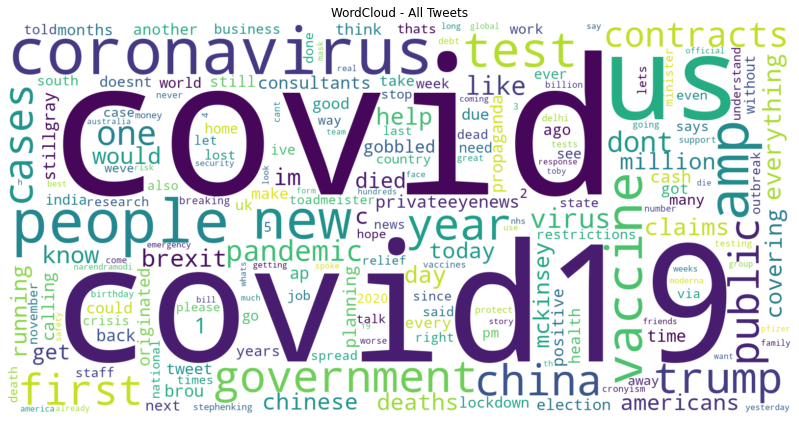

In [ ]:
plot_wordcloud("WordCloud - All Tweets", bag_of_words)